In [2]:
# These libraries may be useful to you

from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

#import gensim
#import gensim.corpora as corpora
#from gensim.utils import simple_preprocess
#from gensim.models import CoherenceModel,LdaMulticore, Phrases 
#from gensim.models.phrases import Phraser 
#from gensim.corpora import Dictionary

import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')

In [3]:
import warnings

def fxn():
    warnings.warn("deprecated", DeprecationWarning)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    fxn()

In [4]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


Exception in Tkinter callback
Traceback (most recent call last):
  File "c:\Users\trist\anaconda3\lib\tkinter\__init__.py", line 1892, in __call__
    return self.func(*args)
  File "c:\Users\trist\anaconda3\lib\site-packages\nltk\downloader.py", line 1618, in _refresh
    self._fill_table()
  File "c:\Users\trist\anaconda3\lib\site-packages\nltk\downloader.py", line 1744, in _fill_table
    rows = [self._package_to_columns(item) for item in items]
  File "c:\Users\trist\anaconda3\lib\site-packages\nltk\downloader.py", line 1744, in <listcomp>
    rows = [self._package_to_columns(item) for item in items]
  File "c:\Users\trist\anaconda3\lib\site-packages\nltk\downloader.py", line 1900, in _package_to_columns
    row.append(self._ds.status(pkg))
  File "c:\Users\trist\anaconda3\lib\site-packages\nltk\downloader.py", line 863, in status
    pkg_status = [self.status(pkg.id) for pkg in info.packages]
  File "c:\Users\trist\anaconda3\lib\site-packages\nltk\downloader.py", line 863, in <lis

True

In [5]:
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

# Getting to Know the Brown Corpus

In [6]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


In [7]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [8]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))

c:\Users\trist\anaconda3\lib\site-packages\matplotlib\__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
c:\Users\trist\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\Users\trist\anaconda3\lib\site-packages\matplotlib\__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
c:\Users\trist\anaconda3\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
c:\Users\trist\anaconda3\lib\site-packages\matplotlib\__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if

<AxesSubplot:xlabel='category'>

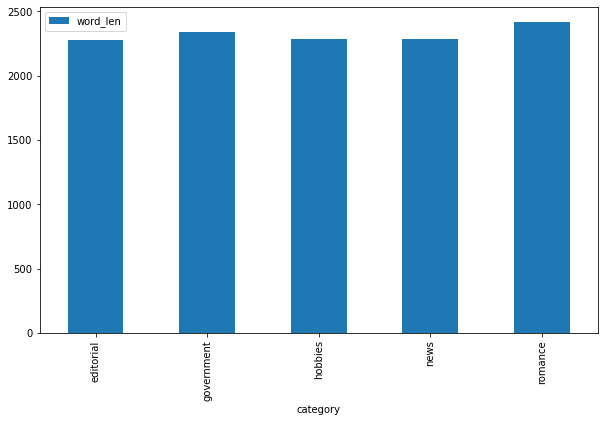

In [9]:
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

In [10]:
count_text_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

c:\Users\trist\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


(166, 4941)

In [11]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

## Q: What do the two data frames count_text_vectors and tfidf_text_vectors hold?

## A: Count_text_vectors converts our strings into a df with frequency representations of words. TFIDF_Text_Vectors is based on numerical frequency but is a df that holds how significant each one of those words are. 

Fitting a Non-Negative Matrix Factorization Model

In [12]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

c:\Users\trist\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [13]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5,max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df["text"])
tfidf_text_vectors.shape

c:\Users\trist\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


(166, 4941)

In [46]:
from sklearn.decomposition import NMF

nmf_text_model = NMF(n_components=5, random_state=42)
W_text_matrix_nmf = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix_nmf = nmf_text_model.components_

c:\Users\trist\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [47]:
df['NMF_topics'] = pd.DataFrame(W_text_matrix).idxmax(axis=1)
group_df = df.groupby(['NMF_topics','category'])['id'].count()
group_df.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))

NMF_topics  category  
0           editorial     62.500000
            government    12.500000
            news          25.000000
1           editorial      9.756098
            hobbies       19.512195
            romance       70.731707
2           editorial      3.076923
            government    40.000000
            hobbies       40.000000
            news          16.923077
3           hobbies        5.555556
            news          94.444444
4           editorial     10.000000
            hobbies       10.000000
            news          80.000000
Name: id, dtype: float64

<AxesSubplot:xlabel='NMF_topics,category'>

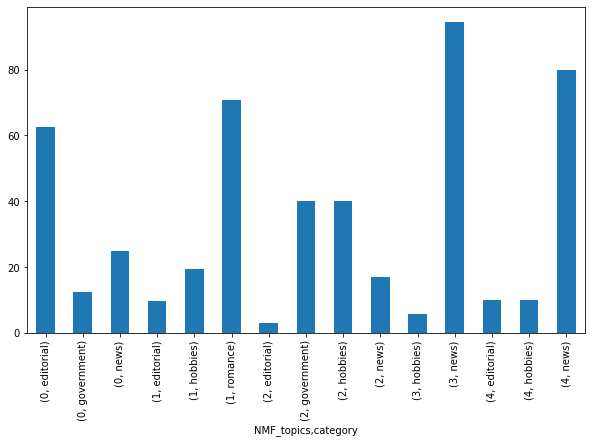

In [48]:
group_df.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).plot.bar(figsize=(10,6))

## Q: How does your five-topic NMF model compare to the original Brown categories?

## A: 

## Original Topics value order: Romance, News, Hobbies, Government, Editorial
## NMF Topics: News seems to hold the highest values with the NMF model. Romance is second. However, in terms of importance in topic 00 is Editorial, Government, News.

Fitting an LSA Model

In [49]:
svd_text_model = TruncatedSVD(n_components = 5, random_state=42)
W_svd_text_matrix_svd = svd_text_model.fit_transform(tfidf_text_vectors)
H_svd_text_matrix_svd = svd_text_model.components_

In [50]:
df['svd_topics'] = pd.DataFrame(W_svd_text_matrix_svd).idxmax(axis=1)
group_df_svd = df.groupby(['svd_topics','category'])['id'].count()
group_df_svd.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))

svd_topics  category  
0           editorial      18.243243
            government     20.270270
            hobbies        24.324324
            news           22.972973
            romance        14.189189
1           romance       100.000000
3           news          100.000000
4           news          100.000000
Name: id, dtype: float64

<AxesSubplot:xlabel='svd_topics,category'>

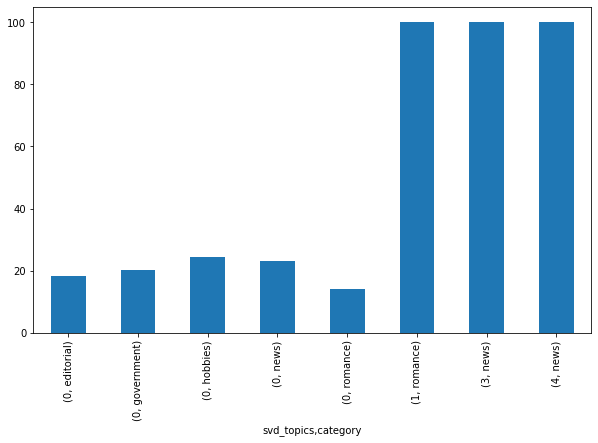

In [51]:
group_df_svd.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).plot.bar(figsize=(10,6))

# call display_topics on your model

## Q: How does your five-topic LSA model compare to the original Brown categories?

## A: News & Romance are the main topics in the LSA models. It's interesting to see how news has the much higher values but the SVD model puts it in category 4. Hobbies are included in the main topic. It is not for the SVD.

Fitting an LDA Model

# Fit your LDA model here

In [54]:
from sklearn.feature_extraction.text import CountVectorizer
count_text_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5,
 max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
from sklearn.decomposition import LatentDirichletAllocation
lda_text_model = LatentDirichletAllocation(n_components = 10, random_state=42)
W_lda_text_matrix_lda = lda_text_model.fit_transform(count_text_vectors)
H_lda_text_matrix_lda = lda_text_model.components_


In [55]:
df['lda_topics'] = pd.DataFrame(W_lda_text_matrix_lda).idxmax(axis=1)
group_df_lda = df.groupby(['lda_topics','category'])['id'].count()
group_df_lda.groupby(level=0).apply(lambda x:100 * x / float(x.sum()))

lda_topics  category  
0           hobbies       61.111111
            news          38.888889
1           editorial     22.222222
            government    33.333333
            hobbies       33.333333
            news          11.111111
2           editorial     38.461538
            government    23.076923
            hobbies       15.384615
            news          23.076923
3           hobbies       33.333333
            romance       66.666667
4           government    25.000000
            romance       75.000000
5           editorial     11.111111
            government     2.222222
            hobbies       17.777778
            news          24.444444
            romance       44.444444
6           government     9.090909
            hobbies        9.090909
            news          81.818182
7           government    45.454545
            hobbies       45.454545
            news           9.090909
8           editorial     37.500000
            government    27.500000
     

<AxesSubplot:xlabel='lda_topics,category'>

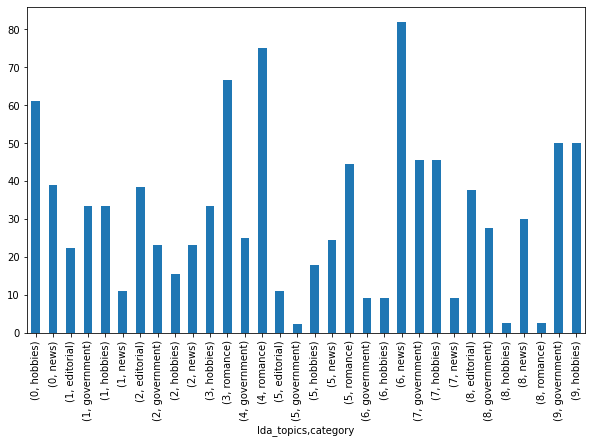

In [56]:
group_df_lda.groupby(level=0).apply(lambda x:100 * x / float(x.sum())).plot.bar(figsize=(10,6))

In [29]:
display_topics(lda_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  clay (0.54)
  game (0.47)
  place (0.45)
  cut (0.45)
  home (0.44)

Topic 01
  pool (0.77)
  use (0.71)
  national (0.70)
  area (0.57)
  good (0.56)

Topic 02
  million (0.60)
  military (0.57)
  sales (0.54)
  aircraft (0.54)
  equipment (0.50)

Topic 03
  feed (3.04)
  said (1.47)
  head (1.08)
  meeting (0.94)
  daily (0.91)

Topic 04
  said (1.83)
  sam (0.67)
  eyes (0.63)
  thought (0.63)
  little (0.58)

Topic 05
  mrs (1.05)
  said (0.88)
  old (0.67)
  mr (0.56)
  man (0.56)

Topic 06
  said (2.73)
  board (0.85)
  000 (0.66)
  court (0.56)
  county (0.55)

Topic 07
  state (1.08)
  medical (0.75)
  shelter (0.68)
  program (0.53)
  service (0.53)

Topic 08
  state (0.85)
  united (0.78)
  states (0.72)
  government (0.70)
  president (0.67)

Topic 09
  fiscal (1.00)
  property (0.86)
  island (0.69)
  tax (0.69)
  state (0.61)


## Q: What inference do you draw from the displayed topics for your LDA model?

## A: The LDA is more specific within topics. Hobbies & News are the main categories here. It has much more categories within each topic compared to the others. The LDA seems to draw specific words from each category to attribute it to the topic

## Q: How does your five-topic LDA model compare to the original Brown categories?

## A: Hobbies & News are the main categories here. It has much more categories within each topic compared to the others. The original has all of the categories relatively the same, with romance being on top.


In [ ]:
lda_display = pyLDAvis.sklearn.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

c:\Users\trist\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [ ]:
pyLDAvis.display(lda_display)

## Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

## A: The PCA shows how the grouping of the topic models are related. Names and words related to editorial pieces are PCA/topic 6. What's the most interested is how PCA 9 is larger in scale and has words like "nations", "state". etc. However, the PCAs surrounding it are highly specific in a category. For example, PCA 8 has all topics related to taxes at the state and federal level and how policies effect those. PCA 3 is very military related. "Said" is the most common word, but second is "state" and "state" is factored more in the PCAs related to Government. The salient graphs demonstrate that even though, "said" is a very common word, it is not as important as "state" or "millions" when describing taxes and such. The salient graph points that "said" is much more important in editorial related topics. 